In [1]:
import librosa
import numpy as np
from skimage.feature import local_binary_pattern, hog
from src.music_recommender.config import Config
from pathlib import Path
from typing import Tuple, Dict, Any
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    explained_variance_score,
    mean_absolute_percentage_error,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    roc_auc_score,
)
from loguru import logger
from scipy.signal import find_peaks
import hashlib
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.feature_selection import (
    SelectKBest,
    mutual_info_regression,
    VarianceThreshold,
)
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from skopt.space import Real, Integer, Categorical
import pickle
import io
import json
from skopt import BayesSearchCV


pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [2]:
cfg = Config()
asp = cfg.paths.processed / "audio"
prc = cfg.paths.processed
intr = cfg.paths.interim
mdl = cfg.paths.models
rep = cfg.paths.reports

In [3]:
class AudioLoader(BaseEstimator, TransformerMixin):
    def __init__(self, sr: int = 22050):
        self.sr = sr

    def fit(self, X, y=None):
        return self

    def transform(self, X) -> np.ndarray:
        """
        X can be:
        - pd.Series of file paths (training)
        - List of file paths (training)
        - Single file path (inference)
        - List of bytes objects (inference - uploaded files)
        - Single bytes object (inference)
        """
        if isinstance(X, (str, Path)):
            X = [X]
        elif isinstance(X, bytes):
            X = [X]
        elif hasattr(X, "tolist"):
            X = X.tolist()

        results = []
        for item in tqdm(X, desc="Loading audio"):
            loaded = self._load_single(item)
            results.append(loaded)

        return np.array(results, dtype=object)

    def _load_single(self, item):
        """
        Returns dict with: audio, sr, path (or pseudo-path for caching)
        """
        if isinstance(item, (str, Path)):
            # Training mode: load from path
            audio, sr = librosa.load(item, sr=self.sr)
            return {"audio": audio, "sr": sr, "path": Path(item), "source_type": "path"}

        elif isinstance(item, bytes):
            audio, sr = librosa.load(io.BytesIO(item), sr=self.sr)

            audio_hash = hashlib.md5(item[:10000]).hexdigest()
            pseudo_path = Path(f"uploaded_{audio_hash}")

            return {
                "audio": audio,
                "sr": sr,
                "path": pseudo_path,
                "source_type": "bytes",
            }

        else:
            raise ValueError(f"Unsupported input type: {type(item)}")

In [4]:
class SpectrogramExtractor(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        new_sr: int = 22050,
        new_ch: int = 1,
        n_fft: int = 2048,
        hop_length: int = 512,
        n_mels: int = 40,
        target_duration: float = 30.0,
        cache_dir: Path = None,
        save_cache: bool = False,
    ) -> None:
        super().__init__()
        self.new_ch = new_ch
        self.new_sr = new_sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.target_duration = target_duration
        self.cache_dir = cache_dir
        self.save_cache = save_cache
        if save_cache and cache_dir:
            cache_dir.mkdir(parents=True, exist_ok=True)

    @staticmethod
    def _resample(
        aud_sr: tuple[np.ndarray, float], new_sr: int
    ) -> tuple[np.ndarray, float]:
        aud, sr = aud_sr
        if sr == new_sr:
            return aud, sr
        if aud.ndim == 1:
            res_aud = librosa.resample(aud, orig_sr=sr, target_sr=new_sr)
        else:
            res_aud = np.stack(
                [
                    librosa.resample(channel, orig_sr=sr, target_sr=new_sr)
                    for channel in aud
                ]
            )
        return res_aud, new_sr

    @staticmethod
    def _rechannel(
        aud_sr: tuple[np.ndarray, float], new_ch: int
    ) -> tuple[np.ndarray, float]:
        aud, sr = aud_sr
        n_ch = 1 if aud.ndim == 1 else aud.shape[0]
        if n_ch == new_ch:
            return aud_sr
        if new_ch == 1:
            res_aud = np.mean(aud, axis=0, keepdims=True)
            return res_aud, sr
        if new_ch == 2:
            res_aud = np.stack([aud, aud])
            return res_aud, sr
        else:
            raise ValueError(f"Unsupported number of channels: {new_ch}")

    @staticmethod
    def _pad_or_truncate(
        aud_sr: tuple[np.ndarray, float], target_duration: float
    ) -> tuple[np.ndarray, float]:
        aud, sr = aud_sr

        target_samples = int(sr * target_duration)
        current_samples = aud.shape[-1] if aud.ndim > 1 else len(aud)

        if current_samples > target_samples:
            if aud.ndim > 1:
                return aud[:, :target_samples], sr
            else:
                return aud[:target_samples], sr
        elif current_samples < target_samples:
            pad_samples = target_samples - current_samples
            if aud.ndim > 1:
                pad_width = ((0, 0), (0, pad_samples))
            else:
                pad_width = (0, pad_samples)
            return np.pad(aud, pad_width, mode="constant", constant_values=0), sr
        else:
            return aud, sr

    def _get_cache_path(self, audio_path: Path) -> Path:
        """Generate cache path from file path"""
        params_hash = f"{self.n_fft}_{self.hop_length}_{self.n_mels}_{self.new_sr}_{self.new_ch}_{self.target_duration}"
        return self.cache_dir / f"{audio_path.stem}_{params_hash}.npz"

    def _load_spectr(
        self,
        audio_dict: dict,
        n_fft: int = 2048,
        hop_length: int = 512,
        n_mels: int = 40,
    ) -> dict:
        """
        Takes dict with keys: audio, sr, path, source_type
        Returns dict with: mel_spectrogram, stft_spectrogram, audio, sr, path
        """

        audio = audio_dict["audio"]
        sr = audio_dict["sr"]
        audio_path = audio_dict["path"]
        source_type = audio_dict["source_type"]

        # Try to load from cache (only for real file paths)
        if self.save_cache and source_type == "path":
            cache_path = self._get_cache_path(audio_path)
            if cache_path.exists():
                try:
                    cached = np.load(cache_path)
                    return {
                        "mel_spectrogram": cached["mel_spectrogram"],
                        "stft_spectrogram": cached["stft_spectrogram"],
                        "audio": cached["audio"],
                        "sr": float(cached["sr"]),
                        "path": audio_path,
                    }
                except Exception as e:
                    # If cache is corrupted, recompute
                    pass

        try:
            aud_sr = (audio, sr)
            aud_sr = self._pad_or_truncate(
                aud_sr=aud_sr, target_duration=self.target_duration
            )
            aud_sr = self._rechannel(aud_sr=aud_sr, new_ch=self.new_ch)
            aud_sr = self._resample(aud_sr=aud_sr, new_sr=self.new_sr)
            aud, sr = aud_sr

            # Compute STFT for features that need it
            stft = librosa.stft(aud, n_fft=n_fft, hop_length=hop_length)
            stft_mag = np.abs(stft)

            # Compute mel spectrogram
            mel_spect = librosa.feature.melspectrogram(
                y=aud, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
            )
            mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

            # Save to cache only for real file paths
            if self.save_cache and source_type == "path":
                cache_path = self._get_cache_path(audio_path)
                np.savez_compressed(
                    cache_path,
                    mel_spectrogram=mel_spect_db,
                    stft_spectrogram=stft_mag,
                    audio=aud,
                    sr=sr,
                )

            return {
                "mel_spectrogram": mel_spect_db,
                "stft_spectrogram": stft_mag,
                "audio": aud,
                "sr": sr,
                "path": audio_path,
            }
        except Exception as e:
            raise ValueError(f"Error processing audio from {audio_path}: {e}")

    def fit(self, X, y=None):
        return self

    def transform(self, X) -> np.ndarray:
        """X is now array of dicts from AudioLoader"""
        results = []
        for audio_dict in tqdm(X, desc="Computing spectrograms"):
            result = self._load_spectr(
                audio_dict,
                n_fft=self.n_fft,
                hop_length=self.hop_length,
                n_mels=self.n_mels,
            )
            results.append(result)
        return np.array(results, dtype=object)

In [5]:
audio_data = pd.read_csv(prc / "matched_metadata.csv")
audio_data.head()

,track_id,track_title,artist_name,album_title,name,artists,album,year,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,10,Freeway,Kurt Vile,Constant Hitmaker,Freeway,['Kurt Vile'],Constant Hitmaker,2008,2008-03-04,0.606,0.916,6,-8.162,1,0.0371,0.1400,0.356,0.1320,0.8890,111.563,161173,4.0
1,237,Garbage and (Garbage and Fire),Barnacled,6,Garbage and (garbage On Fire),['Barnacled'],6,2003,2003-01-01,0.280,0.640,11,-7.799,0,0.1230,0.3490,0.675,0.1360,0.0537,140.368,449467,4.0
2,238,France Attacks,Barnacled,6,France Attacks,['Barnacled'],6,2003,2003-01-01,0.192,0.411,2,-9.445,1,0.0655,0.5390,0.709,0.0909,0.1390,56.929,820707,4.0
3,459,Machines and Muscles,CAVE,Butthash,Machines and Muscles,['Cave'],Psychic Psummer,2009,2009-05-26,0.584,0.918,7,-9.883,1,0.0345,0.0254,0.770,0.3480,0.1140,108.305,236960,5.0
4,459,Machines and Muscles,CAVE,Butthash,Machines and Muscles,['Cave'],Release,2014,2014-10-21,0.415,0.646,2,-12.022,1,0.0399,0.0189,0.948,0.0965,0.1230,93.887,303680,5.0


In [6]:
bins = [0, 80, 100, 120, 140, 170, float("inf")]
numeric_labels = [0, 1, 2, 3, 4, 5]  # Now 6 labels for 6 bins

audio_data["tempo_bins"] = pd.cut(
    audio_data["tempo"], bins=bins, labels=numeric_labels, right=False
)

In [7]:
X = audio_data["track_id"].map(lambda id: asp / f"{str(id).zfill(6)}.mp3")
y = audio_data[
    [
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo_bins",
    ]
]

In [8]:
y.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo_bins
0,0.606,0.916,6,-8.162,1,0.0371,0.1400,0.356,0.1320,0.8890,2
1,0.280,0.640,11,-7.799,0,0.1230,0.3490,0.675,0.1360,0.0537,4
2,0.192,0.411,2,-9.445,1,0.0655,0.5390,0.709,0.0909,0.1390,0
3,0.584,0.918,7,-9.883,1,0.0345,0.0254,0.770,0.3480,0.1140,2
4,0.415,0.646,2,-12.022,1,0.0399,0.0189,0.948,0.0965,0.1230,1


In [9]:
print(y["tempo_bins"].max(), y["tempo_bins"].min())

5 0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(
    f"X_train:{len(X_train)}, X_test: {len(X_test)}, y_train: {len(y_train)}, y_test: {len(y_test)}"
)

X_train:1383, X_test: 346, y_train: 1383, y_test: 346


In [11]:
class StatsFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        sr: float = 22050,
        hop_length: int = 512,
        n_fft: int = 2048,
        n_mfcc: int = 13,
        n_chroma: int = 12,
        f0_min: float = 65.41,
        f0_max: float = 2093.0,
        enable_cache: bool = True,
        cache_path: Path = None,
    ) -> None:
        super().__init__()
        self.sr = sr
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.n_chroma = n_chroma
        self.n_mfcc = n_mfcc
        self.f0_min = f0_min
        self.f0_max = f0_max
        self.enable_cache = enable_cache
        self.cache_path = cache_path
        if self.enable_cache and cache_path:
            self.cache_path.mkdir(parents=True, exist_ok=True)

    def _get_cache_key(self, audio_path: Path, source_type: str) -> str | None:
        """Generate cache key from path"""
        if source_type != "path":
            return None  # Don't cache uploaded files

        params_str = f"{audio_path}_{self.sr}_{self.hop_length}_{self.n_fft}_{self.n_chroma}_{self.n_mfcc}_{self.f0_min}_{self.f0_max}"
        return hashlib.md5(params_str.encode()).hexdigest()

    def _get_cache_file(self, cache_key: str) -> Path:
        return self.cache_path / f"{cache_key}.pkl"

    def _load_from_cache(self, cache_key: str):
        if cache_key is None:
            return None

        cache_file = self._get_cache_file(cache_key)
        if cache_file.exists():
            try:
                with open(cache_file, "rb") as f:
                    return pickle.load(f)
            except:
                return None
        return None

    def _save_to_cache(self, cache_key: str, stats: dict):
        """Save features to cache"""
        if cache_key is None:
            return

        cache_file = self._get_cache_file(cache_key)
        try:
            with open(cache_file, "wb") as f:
                pickle.dump(stats, f)
        except:
            pass

    @staticmethod
    def make_stats(feature_array, features_name):
        return {
            f"{features_name}_mean": np.mean(feature_array),
            f"{features_name}_std": np.std(feature_array),
            f"{features_name}_min": np.min(feature_array),
            f"{features_name}_max": np.max(feature_array),
            f"{features_name}_median": np.median(feature_array),
            f"{features_name}_q25": np.percentile(feature_array, 25),
            f"{features_name}_q75": np.percentile(feature_array, 75),
        }

    @staticmethod
    def temporal_extract(
        audio: np.ndarray, stft_spectrogram: np.ndarray, sr: float, hop_length: int
    ):
        # Use STFT spectrogram for RMS
        rms = librosa.feature.rms(S=stft_spectrogram, hop_length=hop_length)
        zcr = librosa.feature.zero_crossing_rate(y=audio, hop_length=hop_length)

        envelope = rms[0]
        temporal_features = {}

        if len(envelope) > 0 and np.max(envelope) > 0:
            envelope_norm = envelope / np.max(envelope)

            # Attack time (time to reach 90% of max amplitude)
            attack_threshold = 0.9
            attack_frame = np.argmax(envelope_norm >= attack_threshold)
            temporal_features["attack_time"] = (attack_frame * hop_length) / sr

            # Temporal centroid (center of mass in time)
            times = np.arange(len(envelope_norm)) * hop_length / sr
            temporal_features["temporal_centroid"] = np.sum(times * envelope_norm) / (
                np.sum(envelope_norm) + 1e-8
            )
        else:
            temporal_features["attack_time"] = 0.0
            temporal_features["temporal_centroid"] = 0.0

        frame_features = {
            "zcr": zcr.flatten(),
            "rms": rms.flatten(),
        }

        frame_features.update(temporal_features)
        return frame_features

    @staticmethod
    def spectral_extract(
        audio: np.ndarray,
        stft_spectrogram: np.ndarray,
        sr: float,
        hop_length: int,
        n_mfcc: int,
    ):
        spectral_centroid = librosa.feature.spectral_centroid(
            S=stft_spectrogram, sr=sr, hop_length=hop_length
        )
        spectral_bandwidth = librosa.feature.spectral_bandwidth(
            S=stft_spectrogram, sr=sr, hop_length=hop_length
        )
        spectral_rolloff = librosa.feature.spectral_rolloff(
            S=stft_spectrogram, sr=sr, hop_length=hop_length
        )
        spectral_flatness = librosa.feature.spectral_flatness(
            S=stft_spectrogram, hop_length=hop_length
        )
        spectral_flux = librosa.onset.onset_strength(S=stft_spectrogram, sr=sr)

        mfccs = librosa.feature.mfcc(
            S=librosa.power_to_db(stft_spectrogram**2),
            sr=sr,
            n_mfcc=n_mfcc,
            hop_length=hop_length,
        )

        return {
            "spectral_centroid": spectral_centroid.flatten(),
            "spectral_bandwidth": spectral_bandwidth.flatten(),
            "spectral_rolloff": spectral_rolloff.flatten(),
            "spectral_flatness": spectral_flatness.flatten(),
            "spectral_flux": spectral_flux,
            "mfccs": mfccs,  # Shape: (13, n_frames)
        }

    @staticmethod
    def extract_rhythm_features(audio: np.ndarray, sr: float):
        tempo, beats = librosa.beat.beat_track(y=audio, sr=sr)
        onset_env = librosa.onset.onset_strength(y=audio, sr=sr)

        # Compute beat strength only if beats detected
        beat_strength = np.mean(onset_env[beats]) if len(beats) > 0 else 0.0
        onset_rate = len(beats) / (len(audio) / sr) if len(audio) > 0 else 0.0
        if isinstance(tempo, np.ndarray):
            tempo = float(np.median(tempo))
        else:
            tempo = float(tempo)
        return {
            "tempo": tempo,  # Scalar
            "beat_strength": beat_strength,  # Scalar
            "onset_rate": onset_rate,  # Scalar
            "onset_strength": onset_env,  # Time series
        }

    @staticmethod
    def extract_chroma_features(
        audio: np.ndarray, sr: float, hop_length: int, n_chroma: int
    ):
        chroma = librosa.feature.chroma_stft(
            y=audio, sr=sr, hop_length=hop_length, n_chroma=n_chroma
        )

        return {
            "chroma": chroma,
        }

    @staticmethod
    def extract_hpss_features(audio: np.ndarray):
        y_harmonic, y_percussive = librosa.effects.hpss(audio)

        h_energy = np.mean(y_harmonic**2)
        p_energy = np.mean(y_percussive**2)

        return {
            "harmonic_percussive_ratio": h_energy / (p_energy + 1e-8),  # Scalar
            "harmonic_energy": h_energy,  # Scalar
            "percussive_energy": p_energy,  # Scalar
        }, y_harmonic  # Return harmonic component for further analysis

    @staticmethod
    def extract_harmonic_features(
        y_harmonic, sr, hop_length=512, n_fft=2048, f0_min=65.41, f0_max=2093.0
    ):
        features = {}

        # Get fundamental frequency estimates
        f0, voiced_flag, voiced_probs = librosa.pyin(
            y_harmonic,
            fmin=f0_min,
            fmax=f0_max,
            sr=sr,
            hop_length=hop_length,
        )

        # Compute STFT
        stft = librosa.stft(y_harmonic, n_fft=n_fft, hop_length=hop_length)
        mag_spec = np.abs(stft)
        freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

        # Use only voiced frames
        valid_indices = np.where(voiced_flag)[0]
        valid_f0 = f0[voiced_flag]

        if len(valid_f0) > 0:
            inharmonicity_values = []
            t1_values = []
            t2_values = []
            t3_values = []

            for idx, f0_val in zip(valid_indices, valid_f0):
                if np.isnan(f0_val) or f0_val <= 0:
                    continue

                frame_spec = mag_spec[:, idx]

                # --- INHARMONICITY CALCULATION ---
                peaks, properties = find_peaks(
                    frame_spec, height=np.max(frame_spec) * 0.1
                )
                peak_freqs = freqs[peaks]
                peak_mags = properties["peak_heights"]

                if len(peak_freqs) > 0:
                    sorted_idx = np.argsort(peak_mags)[::-1]
                    peak_freqs = peak_freqs[sorted_idx[:10]]
                    peak_mags = peak_mags[sorted_idx[:10]]

                    deviations = []
                    for n in range(1, min(8, len(peak_freqs) + 1)):
                        expected_freq = f0_val * n
                        if expected_freq < freqs[-1]:
                            closest_idx = np.argmin(np.abs(peak_freqs - expected_freq))
                            deviation = (
                                np.abs(peak_freqs[closest_idx] - expected_freq)
                                / expected_freq
                            )
                            deviations.append(deviation)

                    if deviations:
                        inharmonicity_values.append(np.mean(deviations))

                # --- TRISTIMULUS CALCULATION ---
                harmonic_energies = []
                for n in range(1, 11):
                    harmonic_freq = f0_val * n
                    if harmonic_freq >= freqs[-1]:
                        break

                    bin_idx = np.argmin(np.abs(freqs - harmonic_freq))
                    start_bin = max(0, bin_idx - 3)
                    end_bin = min(len(frame_spec), bin_idx + 4)
                    energy = np.sum(frame_spec[start_bin:end_bin])
                    harmonic_energies.append(energy)

                if len(harmonic_energies) >= 5:
                    total_energy = np.sum(harmonic_energies) + 1e-8

                    t1 = harmonic_energies[0] / total_energy
                    t2 = np.sum(harmonic_energies[1:4]) / total_energy
                    t3 = np.sum(harmonic_energies[4:]) / total_energy

                    t1_values.append(t1)
                    t2_values.append(t2)
                    t3_values.append(t3)

            # Aggregate features
            features["inharmonicity"] = (
                np.mean(inharmonicity_values) if inharmonicity_values else 0.0
            )
            features["tristimulus_1"] = np.mean(t1_values) if t1_values else 0.0
            features["tristimulus_2"] = np.mean(t2_values) if t2_values else 0.0
            features["tristimulus_3"] = np.mean(t3_values) if t3_values else 0.0
            features["f0_mean"] = np.mean(valid_f0)
            features["f0_std"] = np.std(valid_f0)
            features["voiced_ratio"] = np.sum(voiced_flag) / len(voiced_flag)
        else:
            # No voiced frames
            features["inharmonicity"] = 0.0
            features["tristimulus_1"] = 0.0
            features["tristimulus_2"] = 0.0
            features["tristimulus_3"] = 0.0
            features["f0_mean"] = 0.0
            features["f0_std"] = 0.0
            features["voiced_ratio"] = 0.0

        return features

    def extract_all_features(self, audio: np.ndarray, stft_spectrogram: np.ndarray):
        all_features = {}

        all_features.update(
            self.temporal_extract(audio, stft_spectrogram, self.sr, self.hop_length)
        )

        all_features.update(
            self.spectral_extract(
                audio, stft_spectrogram, self.sr, self.hop_length, self.n_mfcc
            )  # ← Pass n_mfcc
        )

        all_features.update(self.extract_rhythm_features(audio, self.sr))

        all_features.update(
            self.extract_chroma_features(audio, self.sr, self.hop_length, self.n_chroma)
        )

        hpss_features, y_harmonic = self.extract_hpss_features(audio)
        all_features.update(hpss_features)

        all_features.update(
            self.extract_harmonic_features(
                y_harmonic,
                self.sr,
                self.hop_length,
                self.n_fft,
                self.f0_min,
                self.f0_max,
            )  # ← Pass all params
        )

        return all_features

    def compute_statistics(self, features: Dict[str, Any]) -> Dict[str, float]:
        """Convert all features to statistics (scalars)"""
        stats = {}

        for key, val in features.items():
            # Handle different feature types
            if isinstance(val, (int, float, np.integer, np.floating)):
                # Already a scalar (tempo, attack_time, etc.)
                stats[key] = float(val)

            elif isinstance(val, np.ndarray):
                if val.ndim == 1:
                    # 1D time series (RMS, spectral_centroid, etc.)
                    stats.update(self.make_stats(val, key))

                elif val.ndim == 2:
                    # 2D features (MFCCs, chroma)
                    if key == "mfccs":
                        # MFCCs: shape (13, n_frames)
                        for i in range(val.shape[0]):  # Iterate over 13 coefficients
                            mfcc_i = val[i, :]
                            stats.update(self.make_stats(mfcc_i, f"mfcc_{i}"))

                    elif key == "chroma":
                        # Chroma: shape (12, n_frames)
                        for i in range(val.shape[0]):  # Iterate over 12 pitch classes
                            chroma_i = val[i, :]
                            stats.update(self.make_stats(chroma_i, f"chroma_{i}"))

                    else:
                        # Generic 2D handling
                        for i in range(val.shape[0]):
                            stats.update(self.make_stats(val[i, :], f"{key}_{i}"))

        return stats

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """X is array of dicts from SpectrogramExtractor"""
        feature_vectors = []

        for item in tqdm(X, desc="Extracting features"):
            audio = item["audio"]
            stft_spectrogram = item["stft_spectrogram"]
            audio_path = item.get("path")

            # Determine source type from path
            source_type = (
                "path"
                if (audio_path and not str(audio_path).startswith("uploaded_"))
                else "bytes"
            )

            stats = None

            # Try cache only for real files
            if self.enable_cache and self.cache_path:
                cache_key = self._get_cache_key(audio_path, source_type)
                stats = self._load_from_cache(cache_key)

            if stats is None:
                features = self.extract_all_features(audio, stft_spectrogram)
                stats = self.compute_statistics(features)

                # Save to cache only for real files
                if self.enable_cache and self.cache_path:
                    cache_key = self._get_cache_key(audio_path, source_type)
                    self._save_to_cache(cache_key, stats)

            feature_vectors.append(stats)

        return pd.DataFrame(feature_vectors)

In [12]:
# Basic usage - extract features and train a model
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Extraction pipeline
extraction_pipeline = Pipeline(
    [
        ("audio_loader", AudioLoader(sr=22050)),
        (
            "spectrogram",
            SpectrogramExtractor(
                new_sr=22050, save_cache=True, cache_dir=intr / "spectrogram_cache"
            ),
        ),
        (
            "features",
            StatsFeatureExtractor(
                sr=22050, enable_cache=True, cache_path=intr / "stats_feat"
            ),
        ),
    ]
)

In [13]:
X_train_extracted = extraction_pipeline.fit_transform(X_train)

Extracting features: 100%|██████████| 1383/1383 [00:00<00:00, 4335.75it/s]


In [14]:
X_test_extracted = extraction_pipeline.transform(X_test)

Extracting features: 100%|██████████| 346/346 [00:00<00:00, 4213.62it/s]
/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [15]:
X_train_extracted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Columns: 246 entries, zcr_mean to voiced_ratio
dtypes: float32(203), float64(43)
memory usage: 1.5 MB


In [16]:
len(X_train_extracted.columns.to_list())

246

In [17]:
def multi_output_mutual_info(X, y):
    if len(y.shape) == 1:
        return mutual_info_regression(X, y)

    mi_scores = np.zeros(X.shape[1])
    for i in range(y.shape[1]):
        mi_scores += mutual_info_regression(X, y[:, i])

    return mi_scores / y.shape[1]


class ReduceNumFeature(BaseEstimator, TransformerMixin):
    def __init__(self, k=150, variance_thershold=0.95) -> None:
        super().__init__()
        self.k = k
        self.variance_filter = None
        self.correlation_columns_to_drop = None
        self.selector = None
        self.variance_thershold = variance_thershold

    def fit(self, X, y=None):
        self.variance_filter = VarianceThreshold(threshold=self.variance_thershold)
        X_filt_var = self.variance_filter.fit_transform(X)
        print(f"After variance filter: {X_filt_var.shape[1]} features")

        X_filt_var_df = pd.DataFrame(X_filt_var)
        correlation_matrix = X_filt_var_df.corr().abs()

        upper = correlation_matrix.where(
            np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
        )
        self.correlation_columns_to_drop = [
            column for column in upper.columns if any(upper[column] > 0.95)
        ]

        X_filt_uncorr = X_filt_var_df.drop(
            columns=self.correlation_columns_to_drop
        ).values
        print(f"After correlation filter: {X_filt_uncorr.shape[1]} features")

        if y is not None:
            k_actual = min(self.k, X_filt_uncorr.shape[1])
            self.selector = SelectKBest(multi_output_mutual_info, k=k_actual)
            self.selector.fit(X_filt_uncorr, y)
            print(
                f"After SelectKBest: {self.selector.transform(X_filt_uncorr).shape[1]} features"
            )

        return self

    def transform(self, X):
        X_filt_var = self.variance_filter.transform(X)

        X_filt_var_df = pd.DataFrame(X_filt_var)
        X_filt_uncorr = X_filt_var_df.drop(
            columns=self.correlation_columns_to_drop
        ).values

        if self.selector is not None:
            X_filt_selected = self.selector.transform(X_filt_uncorr)
        else:
            X_filt_selected = X_filt_uncorr

        return X_filt_selected


reducer = ReduceNumFeature(k=75)
reducer.fit(X_train_extracted, y_train)
X_train_reduced = reducer.transform(X_train_extracted)
X_test_reduced = reducer.transform(X_test_extracted)
print(f"X_train_reduced shape: {X_train_reduced.shape}")
print(f"X_test_reduced shape: {X_test_reduced.shape}")

After variance filter: 120 features
After correlation filter: 69 features
After SelectKBest: 69 features
X_train_reduced shape: (1383, 69)
X_test_reduced shape: (346, 69)


In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_extracted)
X_test_pca = pca.transform(X_test_extracted)

print(f"PCA reduced to {X_train_pca.shape[1]} components")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.3f}")

PCA reduced to 4 components
Explained variance: 0.959


In [19]:
X_train_pca.shape

(1383, 4)

In [20]:
SCORING_METRICS = {
    "regression": {
        "r2": "r2",
        "neg_mae": "neg_mean_absolute_error",
        "neg_rmse": "neg_root_mean_squared_error",
        "neg_mape": "neg_mean_absolute_percentage_error",
        "explained_variance": "explained_variance",
    },
    "classification": {
        "accuracy": "accuracy",
        "f1_macro": "f1_macro",
        "f1_weighted": "f1_weighted",
        "precision_macro": "precision_macro",
        "recall_macro": "recall_macro",
        "balanced_accuracy": "balanced_accuracy",
    },
}

In [21]:
y_train_df = pd.DataFrame(y_train, columns=y.columns)
y_test_df = pd.DataFrame(y_test, columns=y.columns)

In [22]:
target_groups = {
    "regression": {
        "energy_mood": ["energy", "valence", "danceability"],
        "production": ["loudness", "acousticness", "instrumentalness", "liveness"],
        "structure": ["speechiness"],
    },
"classification": {
    "key": ["key"],
    "mode": ["mode"], 
    "tempo_bins": ["tempo_bins"]
}}

In [23]:
model_test = {
    "regression": {
        "Ridge": {
            "base_model": Ridge(),
            "param_grid": {
                "estimator__alpha": Real(0.1, 10.0, prior="log-uniform"),
                "estimator__solver": Categorical(["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]),
            },
        },
        "Lasso": {
            "base_model": Lasso(),
            "param_grid": {
                "estimator__alpha": Real(0.0001, 1.0, prior="log-uniform"),
                "estimator__selection": Categorical(["cyclic", "random"]),
            },
        },
        "ElasticNet": {
            "base_model": ElasticNet(),
            "param_grid": {
                "estimator__alpha": Real(0.0001, 1.0, prior="log-uniform"),
                "estimator__l1_ratio": Real(0.1, 1.0),
                "estimator__selection": Categorical(["cyclic", "random"]),
            },
        },
        "Random Forest": {
            "base_model": RandomForestRegressor(random_state=42),
            "param_grid": {
                "estimator__n_estimators": Integer(150, 350),  # Extended from 100-300
                "estimator__max_depth": Integer(10, 20),
                "estimator__min_samples_split": Integer(2, 8),
                "estimator__min_samples_leaf": Integer(3, 8),
                "estimator__max_features": Categorical(["sqrt", "log2", None]),
            },
        },
        "XGBoost": {
            "base_model": XGBRegressor(random_state=42),
            "param_grid": {
                "estimator__n_estimators": Integer(200, 700),  # Extended from 200-600
                "estimator__max_depth": Integer(8, 15),
                "estimator__learning_rate": Real(0.01, 0.05, prior="log-uniform"),
                "estimator__subsample": Real(0.6, 1.0),
                "estimator__colsample_bytree": Real(0.6, 1.0),
                "estimator__gamma": Real(0, 1.0),
            },
        },
        "SVM": {
            "base_model": SVR(kernel="rbf"),
            "param_grid": {
                "estimator__C": Real(0.1, 100.0, prior="log-uniform"),
                "estimator__gamma": Real(0.00001, 0.01, prior="log-uniform"),
                "estimator__epsilon": Real(0.01, 0.2),
            },
        },
    },
    "classification": {
        "Random Forest": {
            "base_model": RandomForestClassifier(random_state=42, class_weight='balanced'),
            "param_grid": {
                "estimator__n_estimators": Integer(150, 350),  # Extended from 150-300
                "estimator__max_depth": Integer(8, 20),
                "estimator__min_samples_split": Integer(2, 10),
                "estimator__min_samples_leaf": Integer(3, 6),
                "estimator__max_features": Categorical(["sqrt", "log2", None]),
                "estimator__bootstrap": Categorical([True, False]),
            },
        },
        "XGBoost": {
            "base_model": XGBClassifier(random_state=42),
            "param_grid": {
                "estimator__n_estimators": Integer(300, 700),  # Keep as is (was already extended)
                "estimator__max_depth": Integer(8, 15),
                "estimator__learning_rate": Real(0.01, 0.3, prior="log-uniform"),
                "estimator__subsample": Real(0.6, 1.0),
                "estimator__colsample_bytree": Real(0.8, 1.0),
                "estimator__gamma": Real(0, 2.0),
                "estimator__reg_alpha": Real(0, 10.0),  # Extended from 0-5
                "estimator__reg_lambda": Real(0, 30.0),
            },
        },
        "SVM": {
            "base_model": SVC(kernel="rbf", probability=True, random_state=42, class_weight='balanced'),
            "param_grid": {
                "estimator__C": Real(1.0, 20.0, prior="log-uniform"),
                "estimator__gamma": Real(0.001, 0.02, prior="log-uniform"),
            },
        },
    },
}

In [ ]:
n_iter_config = {
    "Ridge": 30,
    "Lasso": 30,
    "ElasticNet": 30,
    "Random Forest": 50,  
    "XGBoost": 50,
    "SVM": 40,
}

In [28]:
results = []
for task_type, models in model_test.items():
    scoring_metrics = SCORING_METRICS[task_type]
    groups = target_groups[task_type]
    
    for group_name, target_cols in groups.items():
        y_train_group = y_train_df[target_cols].values
        y_test_group = y_test_df[target_cols].values
        
        # Determine if we need multi-output wrapper
        is_multi_output = len(target_cols) > 1
        
        for model_name, model_info in models.items():
            print(f"Training {model_name} on {task_type} - {group_name}...")

            base_model = model_info["base_model"]
            
            if task_type == "classification" and model_name == "XGBoost" and not is_multi_output:
                from sklearn.utils.class_weight import compute_class_weight
                classes = np.unique(y_train_group.ravel())
                if len(classes) == 2:
                    class_weights = compute_class_weight('balanced', classes=classes, y=y_train_group.ravel())
                    base_model.set_params(scale_pos_weight=class_weights[1]/class_weights[0])
                
            if is_multi_output:
                if task_type == "regression":
                    model = MultiOutputRegressor(base_model)
                    param_grid = {
                        k.replace("estimator__", "estimator__estimator__"): v 
                        for k, v in model_info["param_grid"].items()
                    }
                else:
                    model = MultiOutputClassifier(base_model)
                    param_grid = {
                        k.replace("estimator__", "estimator__estimator__"): v 
                        for k, v in model_info["param_grid"].items()
                    }
            else:
                model = base_model
                param_grid = model_info["param_grid"]
                y_train_group = y_train_group.ravel()
                y_test_group = y_test_group.ravel()

            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("pca", PCA(n_components=50)),
                ("estimator", model)
            ])
            
            refit_metric = "r2" if task_type == "regression" else "f1_weighted"
            
            if task_type == "classification":
                from sklearn.model_selection import StratifiedKFold
                cv_strategy = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
            else:
                cv_strategy = 4
            
            search = BayesSearchCV(
                estimator=pipe,
                search_spaces=param_grid,
                scoring=scoring_metrics,
                refit=refit_metric,
                cv=cv_strategy,
                n_iter=n_iter_config[model_name],
                n_jobs=-1,
                random_state=42,
            )

            search.fit(X_train_extracted, y_train_group)
            y_pred = search.predict(X_test_extracted)

            result = {
                "task_type": task_type,
                "group": group_name,
                "model": model_name,
                "targets": ", ".join(target_cols),
            }

            if task_type == "regression":
                if not is_multi_output:
                    y_test_group = y_test_group.reshape(-1, 1)
                    y_pred = y_pred.reshape(-1, 1)
                
                result["r2"] = r2_score(y_test_group, y_pred)
                result["neg_mae"] = -mean_absolute_error(y_test_group, y_pred)
                result["neg_rmse"] = -np.sqrt(mean_squared_error(y_test_group, y_pred))
                try:
                    result["neg_mape"] = -mean_absolute_percentage_error(y_test_group, y_pred)
                except:
                    result["neg_mape"] = None
                result["explained_variance"] = explained_variance_score(y_test_group, y_pred)
                for metric in SCORING_METRICS["classification"].values():
                    result[metric] = None
            else:
                result["accuracy"] = accuracy_score(y_test_group, y_pred)
                result["f1_macro"] = f1_score(y_test_group, y_pred, average="macro", zero_division=0)
                result["f1_weighted"] = f1_score(y_test_group, y_pred, average="weighted", zero_division=0)
                result["precision_macro"] = precision_score(y_test_group, y_pred, average="macro", zero_division=0)
                result["recall_macro"] = recall_score(y_test_group, y_pred, average="macro", zero_division=0)
                result["balanced_accuracy"] = balanced_accuracy_score(y_test_group, y_pred)
                
                try:
                    if hasattr(search.best_estimator_.named_steps['estimator'], "predict_proba"):
                        y_proba = search.predict_proba(X_test_extracted)
                        if len(np.unique(y_test_group)) == 2:
                            result["roc_auc_ovr"] = roc_auc_score(y_test_group, y_proba[:, 1] if y_proba.ndim == 2 else y_proba)
                        else:
                            result["roc_auc_ovr"] = roc_auc_score(y_test_group, y_proba, multi_class='ovr', average='weighted')
                    else:
                        result["roc_auc_ovr"] = None
                except Exception as e:
                    print(f"ROC AUC calculation failed: {e}")
                    result["roc_auc_ovr"] = None
                
                for metric in SCORING_METRICS["regression"].values():
                    result[metric] = None
        
            result["best_params"] = str(search.best_params_)
            results.append(result)

results_df = pd.DataFrame(results)
print(results_df)

results_df.to_csv(mdl / "model_comparison_results.csv", index=False)

Training Ridge on regression - energy_mood...
Training Lasso on regression - energy_mood...
Training ElasticNet on regression - energy_mood...
Training Random Forest on regression - energy_mood...
Training XGBoost on regression - energy_mood...
Training SVM on regression - energy_mood...
Training Ridge on regression - production...
Training Lasso on regression - production...
Training ElasticNet on regression - production...
Training Random Forest on regression - production...
Training XGBoost on regression - production...
Training SVM on regression - production...
Training Ridge on regression - structure...
Training Lasso on regression - structure...
Training ElasticNet on regression - structure...
Training Random Forest on regression - structure...
Training XGBoost on regression - structure...
Training SVM on regression - structure...
Training Random Forest on classification - key...
Training XGBoost on classification - key...


/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:46:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:46:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:46:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:46:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain,

Training SVM on classification - key...


/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

Training Random Forest on classification - mode...
Training XGBoost on classification - mode...


/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Training SVM on classification - mode...
Training Random Forest on classification - tempo_bins...
Training XGBoost on classification - tempo_bins...


/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:05:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:05:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:05:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:05:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain,

Training SVM on classification - tempo_bins...
         task_type        group          model  \
0       regression  energy_mood          Ridge   
1       regression  energy_mood          Lasso   
2       regression  energy_mood     ElasticNet   
3       regression  energy_mood  Random Forest   
4       regression  energy_mood        XGBoost   
5       regression  energy_mood            SVM   
6       regression   production          Ridge   
7       regression   production          Lasso   
8       regression   production     ElasticNet   
9       regression   production  Random Forest   
10      regression   production        XGBoost   
11      regression   production            SVM   
12      regression    structure          Ridge   
13      regression    structure          Lasso   
14      regression    structure     ElasticNet   
15      regression    structure  Random Forest   
16      regression    structure        XGBoost   
17      regression    structure            SVM   
18 

In [29]:
results_df.head()

,task_type,group,model,targets,r2,neg_mae,neg_rmse,neg_mape,explained_variance,accuracy,f1_macro,f1_weighted,precision_macro,recall_macro,balanced_accuracy,best_params,roc_auc_ovr,neg_mean_absolute_error,neg_root_mean_squared_error,neg_mean_absolute_percentage_error
0,regression,energy_mood,Ridge,"energy, valence, danceability",0.390175,-0.142383,-0.183073,-0.674158,0.390723,NaN,NaN,NaN,NaN,NaN,NaN,"OrderedDict([('estimator__estimator__alpha', 8.146216961026964), ('estimator__estimator__solver', 'sparse_cg')])",NaN,NaN,NaN,NaN
1,regression,energy_mood,Lasso,"energy, valence, danceability",0.386089,-0.145913,-0.183950,-0.711040,0.386789,NaN,NaN,NaN,NaN,NaN,NaN,"OrderedDict([('estimator__estimator__alpha', 0.007165850265420658), ('estimator__estimator__selection', 'random')])",NaN,NaN,NaN,NaN
2,regression,energy_mood,ElasticNet,"energy, valence, danceability",0.381846,-0.146825,-0.184576,-0.718998,0.382614,NaN,NaN,NaN,NaN,NaN,NaN,"OrderedDict([('estimator__estimator__alpha', 0.015198969741729622), ('estimator__estimator__l1_ratio', 0.5438470633401808), ('estimator__estimator__selection', 'cyclic')])",NaN,NaN,NaN,NaN
3,regression,energy_mood,Random Forest,"energy, valence, danceability",0.411884,-0.141684,-0.180166,-0.734199,0.413520,NaN,NaN,NaN,NaN,NaN,NaN,"OrderedDict([('estimator__estimator__max_depth', 15), ('estimator__estimator__max_features', None), ('estimator__estimator__min_samples_leaf', 3), ('estimator__estimator__min_samples_split', 2), ('estimator__estimator__n_estimators', 350)])",NaN,NaN,NaN,NaN
4,regression,energy_mood,XGBoost,"energy, valence, danceability",0.439326,-0.137015,-0.175537,-0.680886,0.440332,NaN,NaN,NaN,NaN,NaN,NaN,"OrderedDict([('estimator__estimator__colsample_bytree', 1.0), ('estimator__estimator__gamma', 0.05431157271809896), ('estimator__estimator__learning_rate', 0.012760248919985628), ('estimator__estimator__max_depth', 8), ('estimator__estimator__n_estimators', 648), ('estimator__estimator__subsample', 0.6)])",NaN,NaN,NaN,NaN


BEST MODELS FOR EACH TASK:
     task_type       group    best_model                                            targets primary_metric  primary_score                                                                                                                                                                                                                                                                                                                                              best_params
classification         key       XGBoost                                                key    f1_weighted       0.368864                                           OrderedDict([('estimator__colsample_bytree', 0.8), ('estimator__gamma', 0.0), ('estimator__learning_rate', 0.06367864042640069), ('estimator__max_depth', 8), ('estimator__n_estimators', 700), ('estimator__reg_alpha', 0.0), ('estimator__reg_lambda', 30.0), ('estimator__subsample', 0.7096728502759829)])
classification        mode       XGBoos

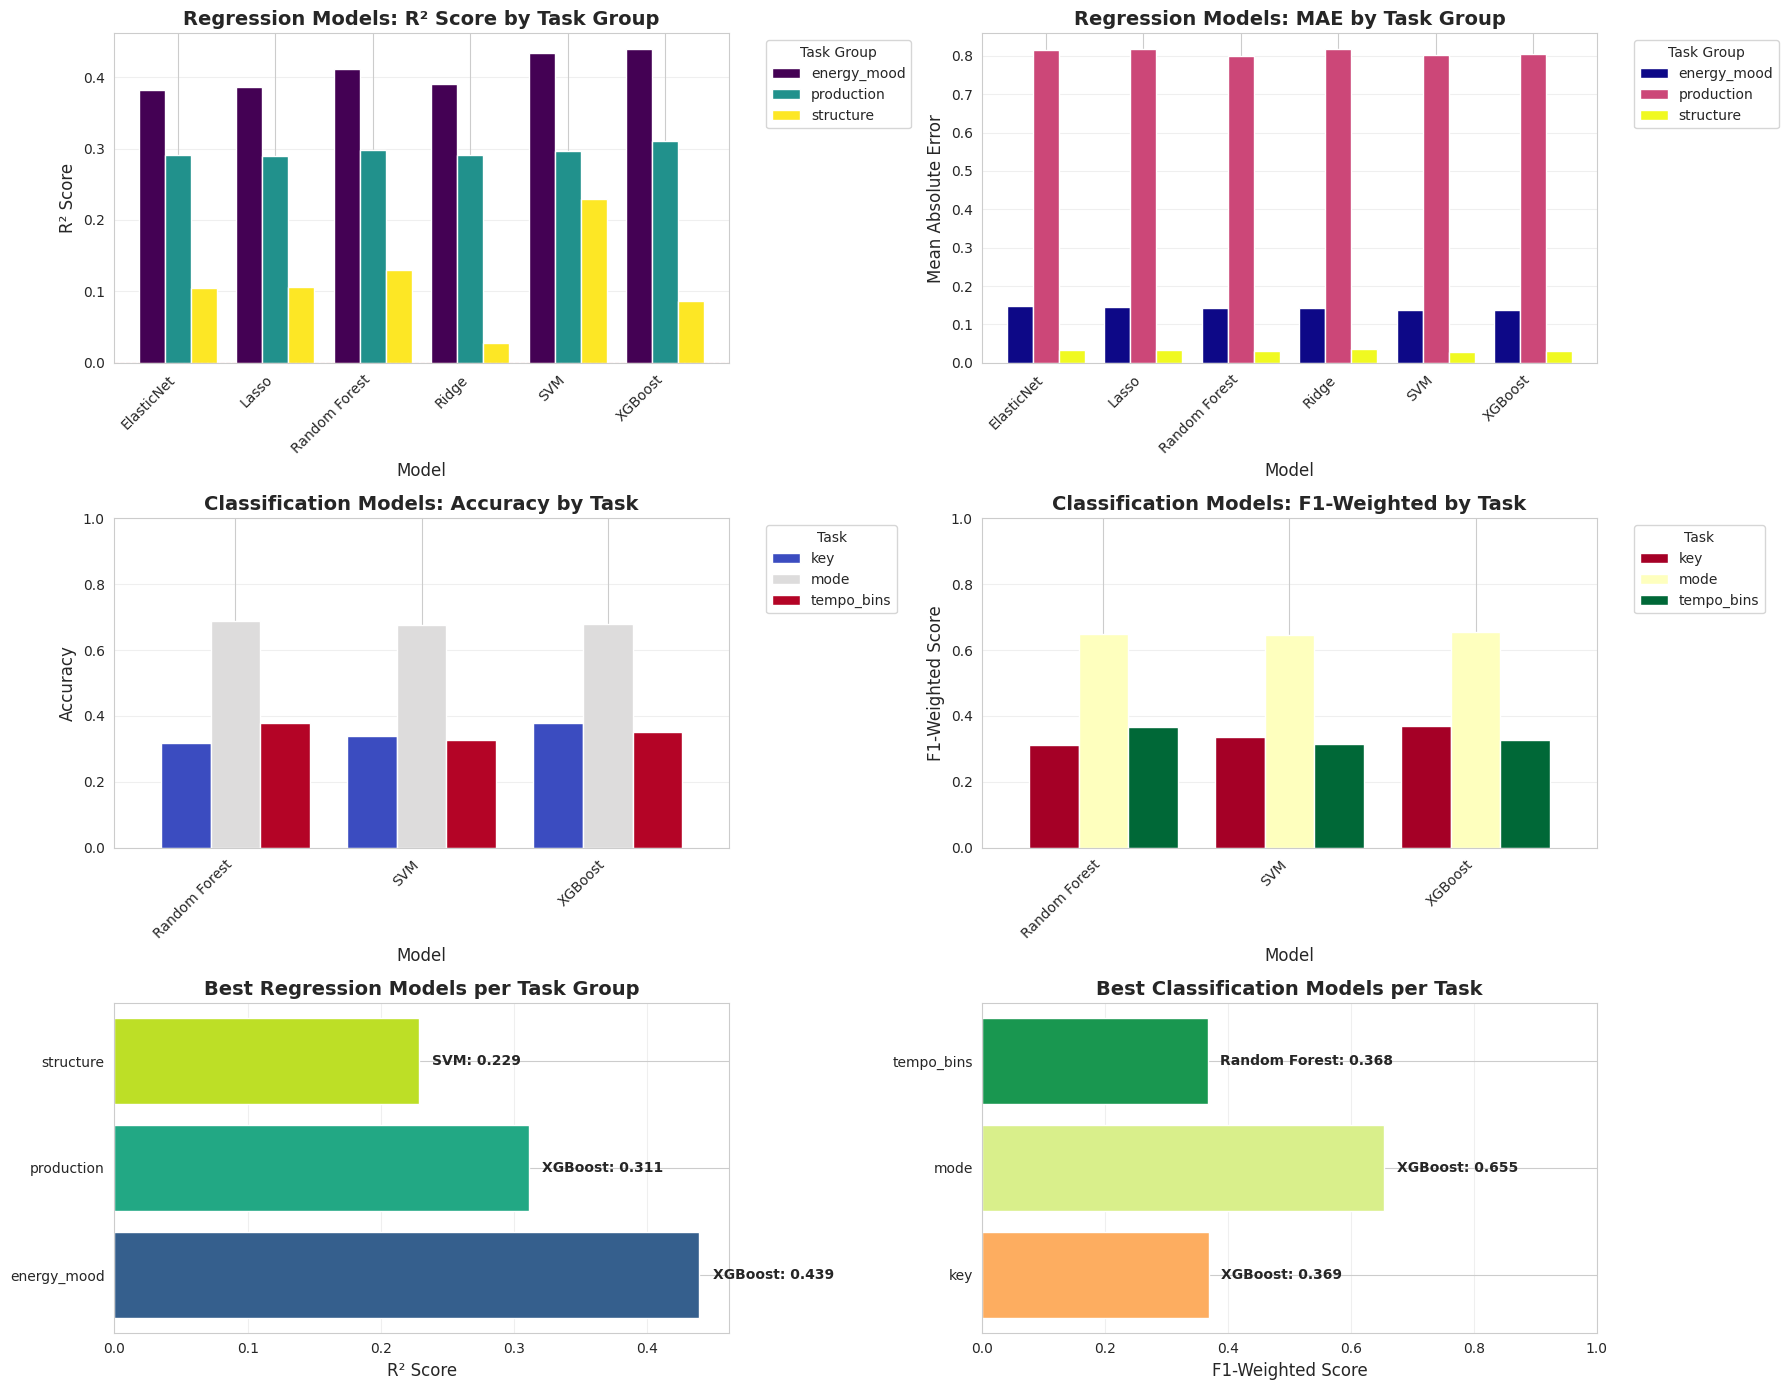

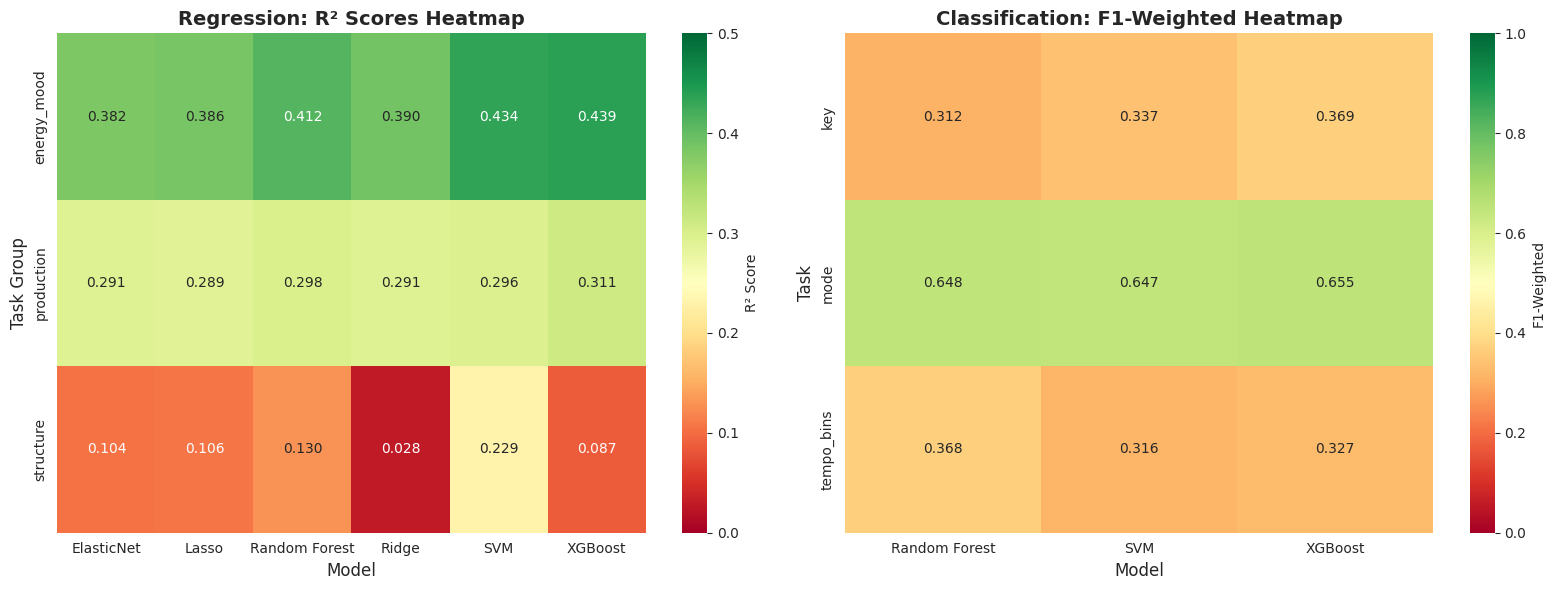


Visualizations saved as:
  - model_comparison_comprehensive.png
  - model_comparison_heatmaps.png
Best models summary saved as: best_models_summary.csv


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# ============================================
# 1. GET BEST MODELS FOR EACH TASK
# ============================================

def get_best_models(df):
    """
    Find the best model for each task group based on primary metrics.
    For regression: use r2 (higher is better)
    For classification: use f1_weighted (higher is better)
    """
    best_models = []
    
    # Group by task_type and group
    for (task_type, group), group_df in df.groupby(['task_type', 'group']):
        if task_type == 'regression':
            # For regression, maximize R²
            best_idx = group_df['r2'].idxmax()
            metric_col = 'r2'
            metric_value = group_df.loc[best_idx, 'r2']
        else:  # classification
            # For classification, maximize F1-weighted
            best_idx = group_df['f1_weighted'].idxmax()
            metric_col = 'f1_weighted'
            metric_value = group_df.loc[best_idx, 'f1_weighted']
        
        best_model = group_df.loc[best_idx]
        best_models.append({
            'task_type': task_type,
            'group': group,
            'best_model': best_model['model'],
            'targets': best_model['targets'],
            'primary_metric': metric_col,
            'primary_score': metric_value,
            'best_params': best_model['best_params']
        })
    
    return pd.DataFrame(best_models)

best_models_df = get_best_models(results_df)
print("=" * 80)
print("BEST MODELS FOR EACH TASK:")
print("=" * 80)
print(best_models_df.to_string(index=False))
print("\n")

# ============================================
# 2. VISUALIZATIONS
# ============================================

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

fig = plt.figure(figsize=(18, 14))

# --- SUBPLOT 1: Regression Tasks Comparison ---
ax1 = plt.subplot(3, 2, 1)
reg_df = results_df[results_df['task_type'] == 'regression'].copy()
reg_pivot = reg_df.pivot_table(index='model', columns='group', values='r2')
reg_pivot.plot(kind='bar', ax=ax1, colormap='viridis', width=0.8)
ax1.set_title('Regression Models: R² Score by Task Group', fontsize=14, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_xlabel('Model', fontsize=12)
ax1.legend(title='Task Group', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# --- SUBPLOT 2: Regression MAE Comparison ---
ax2 = plt.subplot(3, 2, 2)
mae_pivot = reg_df.pivot_table(index='model', columns='group', values='neg_mae')
mae_pivot = -mae_pivot  # Convert to positive MAE
mae_pivot.plot(kind='bar', ax=ax2, colormap='plasma', width=0.8)
ax2.set_title('Regression Models: MAE by Task Group', fontsize=14, fontweight='bold')
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_xlabel('Model', fontsize=12)
ax2.legend(title='Task Group', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# --- SUBPLOT 3: Classification Accuracy ---
ax3 = plt.subplot(3, 2, 3)
cls_df = results_df[results_df['task_type'] == 'classification'].copy()
acc_pivot = cls_df.pivot_table(index='model', columns='group', values='accuracy')
acc_pivot.plot(kind='bar', ax=ax3, colormap='coolwarm', width=0.8)
ax3.set_title('Classification Models: Accuracy by Task', fontsize=14, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=12)
ax3.set_xlabel('Model', fontsize=12)
ax3.legend(title='Task', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1])
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# --- SUBPLOT 4: Classification F1-Weighted ---
ax4 = plt.subplot(3, 2, 4)
f1_pivot = cls_df.pivot_table(index='model', columns='group', values='f1_weighted')
f1_pivot.plot(kind='bar', ax=ax4, colormap='RdYlGn', width=0.8)
ax4.set_title('Classification Models: F1-Weighted by Task', fontsize=14, fontweight='bold')
ax4.set_ylabel('F1-Weighted Score', fontsize=12)
ax4.set_xlabel('Model', fontsize=12)
ax4.legend(title='Task', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, 1])
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

# --- SUBPLOT 5: Best Model Summary (Regression) ---
ax5 = plt.subplot(3, 2, 5)
best_reg = best_models_df[best_models_df['task_type'] == 'regression']
x_pos = np.arange(len(best_reg))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(best_reg)))
bars = ax5.barh(x_pos, best_reg['primary_score'], color=colors)
ax5.set_yticks(x_pos)
ax5.set_yticklabels(best_reg['group'])
ax5.set_xlabel('R² Score', fontsize=12)
ax5.set_title('Best Regression Models per Task Group', fontsize=14, fontweight='bold')
ax5.grid(axis='x', alpha=0.3)

# Add value labels and model names
for i, (bar, model) in enumerate(zip(bars, best_reg['best_model'])):
    width = bar.get_width()
    ax5.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{model}: {width:.3f}', 
             ha='left', va='center', fontsize=10, fontweight='bold')

# --- SUBPLOT 6: Best Model Summary (Classification) ---
ax6 = plt.subplot(3, 2, 6)
best_cls = best_models_df[best_models_df['task_type'] == 'classification']
x_pos = np.arange(len(best_cls))
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(best_cls)))
bars = ax6.barh(x_pos, best_cls['primary_score'], color=colors)
ax6.set_yticks(x_pos)
ax6.set_yticklabels(best_cls['group'])
ax6.set_xlabel('F1-Weighted Score', fontsize=12)
ax6.set_title('Best Classification Models per Task', fontsize=14, fontweight='bold')
ax6.grid(axis='x', alpha=0.3)
ax6.set_xlim([0, 1])

# Add value labels and model names
for i, (bar, model) in enumerate(zip(bars, best_cls['best_model'])):
    width = bar.get_width()
    ax6.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{model}: {width:.3f}', 
             ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(rep/'figures'/'model_comparison_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# Additional Visualization: Heatmap
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Regression heatmap
ax_reg = axes[0]
reg_heatmap_data = reg_df.pivot_table(index='group', columns='model', values='r2')
sns.heatmap(reg_heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            ax=ax_reg, cbar_kws={'label': 'R² Score'}, vmin=0, vmax=0.5)
ax_reg.set_title('Regression: R² Scores Heatmap', fontsize=14, fontweight='bold')
ax_reg.set_xlabel('Model', fontsize=12)
ax_reg.set_ylabel('Task Group', fontsize=12)

# Classification heatmap
ax_cls = axes[1]
cls_heatmap_data = cls_df.pivot_table(index='group', columns='model', values='f1_weighted')
sns.heatmap(cls_heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            ax=ax_cls, cbar_kws={'label': 'F1-Weighted'}, vmin=0, vmax=1)
ax_cls.set_title('Classification: F1-Weighted Heatmap', fontsize=14, fontweight='bold')
ax_cls.set_xlabel('Model', fontsize=12)
ax_cls.set_ylabel('Task', fontsize=12)

plt.tight_layout()
plt.savefig(rep/'figures'/'model_comparison_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# Export Best Models Details
# ============================================
best_models_df.to_csv(mdl/'best_models_summary.csv', index=False)
print("\n" + "=" * 80)
print("Visualizations saved as:")
print("  - model_comparison_comprehensive.png")
print("  - model_comparison_heatmaps.png")
print("Best models summary saved as: best_models_summary.csv")
print("=" * 80)